<a href="https://colab.research.google.com/github/NonMagneticNeedle/vision.ai/blob/master/tinyface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive


In [0]:
import tensorflow as tf
import os
import cv2
import numpy as np
import json
import time
import random

this function takes input images in one folder and bbox annotations in another folder (each annotation in a json file with the image name)
 

> the structure of annotation for x_images/img1should be like :annotations/img1.json 
  


> **{0 :[[(x1,y1),(x2,y2)],[(x3,y3),(x4,y4)]] ;1:[];2:[];3:[[(x5,y5),(x6,y6)]] ;---- } **



that is left top and
right botton coordinates in a dict(list of list of tuples/list)




output is label heatmaps
 {the network outputs C (num of classes) heatmaps and 2 more heatmaps for width and height unlike the paper here we normalize the size wrt to input size
and we skip the offset part here since heatmaps will be half size(by default) so not much of offset, and sigma for heatmaps will depend on diagnal}


In [0]:

n_classes = 1
x_images_path = "/gdrive/My Drive/Akash's Junk Folder/faces/x_images/"
y_annotations_path = "/gdrive/My Drive/Akash's Junk Folder/faces/y_annotations/"
def create_heatmaps(image,anno,num_classes=n_classes,reduction=2):
	w =image.shape[1]//reduction
	h =image.shape[0]//reduction
	size_map_w=np.zeros((h,w))
	size_map_h=np.zeros((h,w))
	heat_maps=[]
	for i in range(num_classes):
		objscxs=[]
		objscys=[]
		objsdiag=[]
		current_class_map=np.zeros((h,w))
		if len(anno[str(i)]) != 0 :

			for obj in anno[str(i)]:
				
				x1=obj[0][0]
				y1=obj[0][1]
				x2=obj[1][0]
				y2=obj[1][1]
				objcenterx = (x1+x2)//(2*reduction)
				objcentery = (y1+y2)//(2*reduction)
				objw = (x2-x1)/image.shape[1]
				objh = (y2-y1)/image.shape[0]
				objd = (objw**2+objh**2)**0.5
				size_map_w[objcentery,objcenterx]=objw
				size_map_h[objcentery,objcenterx]=objh
				objscxs.append(objcenterx)
				objscys.append(objcentery)
				objsdiag.append(objd)
			objscxs=np.array(objscxs)
			objscys=np.array(objscys)
			objsdiag=np.array(objsdiag)

			#print("objscxs,objscys,objsdiag",objscxs,objscys,objsdiag)
			for x in range(w):
				for y in range(h):
					distsq = (x*np.ones_like(objscxs) - objscxs)**2 + (y*np.ones_like(objscys) - objscys )**2
					sigma_sq=0.001/(objsdiag)**2
					sigma_sq = np.minimum(sigma_sq,1.7*np.ones_like(sigma_sq))
					sigma_sq = np.maximum(sigma_sq,1.0*np.ones_like(sigma_sq))
					
					values = np.exp(-distsq/sigma_sq)
					#if np.amax(values)==1:
						#print("max_cent at",y,x)
						#print("distsq,sigma_sq,values",distsq,sigma_sq,values)
					current_class_map[y,x]=np.amax(values)
		heat_maps.append(current_class_map)	
	heat_maps.append(size_map_w)
	heat_maps.append(size_map_h)	
	arr = np.array(heat_maps)	
	return(np.moveaxis(arr, 0, -1))


In [0]:
def random_augment(image,heatmap,gray =False,rand_crop=(200,200)):
	#print(image.shape,heatmap.shape)
	augimage = image
	augheatmap = heatmap
	redn = image.shape[0]//heatmap.shape[0]

	rand_h = np.random.randint(augimage.shape[0]-rand_crop[0]+1)
	rand_w = np.random.randint(augimage.shape[1]-rand_crop[1]+1)
	augimagecrop = augimage[rand_h:rand_h+rand_crop[0],rand_w:rand_w+rand_crop[1],:]
	augheatmapcrop = augheatmap[rand_h//redn:(rand_h+rand_crop[0])//redn,rand_w//redn:(rand_w+rand_crop[1])//redn,:]
	if gray :
		augimagecrop = cv2.cvtColor(augimagecrop, cv2.COLOR_BGR2GRAY)
		augimagecrop =augimagecrop.reshape((rand_crop[0],rand_crop[1],1))
	
	
	return augimagecrop,augheatmapcrop


this function is to visualize the output prediction heatmaps without using maxpooling as non max supression

In [0]:
def visualize_y_heatmap(image,y_heatmap,verbose =1,max_obj_pc=6,min_conf=0.6):
	font = cv2.FONT_HERSHEY_SIMPLEX
	imgh,imgw = image.shape[0],image.shape[1]
	y_heatmaph,y_heatmapw,y_heatmapc = y_heatmap.shape[0],y_heatmap.shape[1],y_heatmap.shape[2]
	sc_w = imgw//y_heatmapw
	sc_h = imgh//y_heatmaph
	y_w = imgw*y_heatmap[:,:,y_heatmapc-2]
	y_h = imgh*y_heatmap[:,:,y_heatmapc-1]
	bbox ={}
	for i in range(y_heatmapc-2):
		c_hmp = y_heatmap[:,:,i]
		objs=[]
		for y in range(y_heatmaph):
			for x in range(y_heatmapw):
				if c_hmp[y,x]>min_conf:
					width = y_w[y,x]
					height = y_h[y,x]
					centerx = sc_w*x
					centery = sc_h*y 
					objs.append([c_hmp[y,x],int(centerx-width/2),int(centery-height/2),int(centerx+width/2),int(centery+height/2)])# list of [confidence,px1,py1,px2,py2]
		# here we sort the list of all possible objs			
		objs.sort(key = lambda x: x[0])
		bbox[i] = objs[0:max_obj_pc]
		if verbose:
			for l in objs[0:max_obj_pc]:
				cv2.rectangle(image,(l[1],l[2]),(l[3],l[4]), (0, 255, 0), 2) 
				cv2.putText(image,str(i),(l[1],l[2]), font,0.5,(10,0,100),1,cv2.LINE_AA)
	if verbose:
		cv2_imshow(image)    
	return bbox


In [0]:

def create_architecture(n_classes=n_classes,input_shape=(None,None,1),reduction=2):
	model = tf.keras.Sequential()
	model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='elu', input_shape=input_shape)) 
	#model.add(tf.keras.layers.Dropout(0.3))
	model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='elu'))
	#model.add(tf.keras.layers.Dropout(0.3))
	model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='elu'))
	#model.add(tf.keras.layers.Dropout(0.3))
	model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3,strides=(2,2), padding='same', activation='elu'))
	#model.add(tf.keras.layers.Dropout(0.3))
	model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='elu'))
	#model.add(tf.keras.layers.Dropout(0.3))
	model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='elu'))
	#model.add(tf.keras.layers.Dropout(0.3))
	model.add(tf.keras.layers.Conv2D(filters=n_classes+2, kernel_size=3, padding='same', activation='sigmoid'))

	model.summary()
	return model	


def centernet_loss(y_true,y_pred):
	pred_c =y_pred[:,:,:,:n_classes]#batch,width,height,k#class heatmaps
	pred_s= y_pred[:,:,:,n_classes:]#size heatmaps
	true_c =y_true[:,:,:,:n_classes]#batch,width,height,k#class guassian heatmaps
	true_s= y_true[:,:,:,n_classes:]#size heatmaps
	c_mask = tf.equal(true_c,1)
	c_mask=tf.dtypes.cast(c_mask, tf.float32)# cmask = 1 where the true loaction of object is in the guassian heatmap/class(value =1)
	tc_mask = tf.reduce_sum(c_mask,axis=-1)#tc_mask =  all the objects of all clases in true heatmap , for N and size loss masking
	# define object loss and size loss
	alpha = 2
	beta = 4
	lambdaobj =1
	lambdasize =0.1
	#mask the log outputs and add 0.00000001 since log 0 = -inf
	N = tf.reduce_sum(tc_mask,axis = [1,2])# Number of keypoints per class
	lk1 = tf.pow((1- pred_c),alpha)*tf.multiply(tf.math.log(pred_c+0.0001),c_mask)
	lk2 = tf.pow((1-true_c),beta)*tf.pow(pred_c,alpha)*tf.multiply(tf.math.log(1-pred_c + 0.0001),(1-c_mask))
	lk = lk1+lk2
	lkf =  -1*tf.divide(tf.reduce_sum(lk,axis = [1,2,3],keepdims=False),(N+0.00001))
	# size loss

	ls = tf.multiply(tf.reduce_sum((pred_s-true_s)**2,axis=-1)**0.5,tc_mask)
	lsf = tf.divide(tf.reduce_sum(ls,axis = [1,2],keepdims=False),(N+0.00001))
	loss =tf.reduce_mean(lambdaobj*lkf + lambdasize+lsf )

	return loss



Here we can actually create heatmaps and store the heatmaps in disk to reduce the time taken for preprocessing when training.But here its not done since heatmaps take a lot of space

In [0]:
model = create_architecture()
model.compile(loss=centernet_loss, optimizer=tf.keras.optimizers.Adam(lr=0.0001))	
#print("loadinng a base model")
#model.load_weights( "C:/Users/Dell/Desktop/my_centernet/11tiny_model.h5")				
x_data_list = []
c = 0
for i_name in os.listdir(x_images_path):
	c+=1
	
	x_data_list.append(i_name.split('.')[0])
	#imm = cv2.imread(x_images_path+i_name)
	#print(c,x_images_path+i_name.split('.')[0],imm.shape)
	if c>200:
		break
print(len( x_data_list ))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, None, None, 32)    320       
_________________________________________________________________
dropout_54 (Dropout)         (None, None, None, 32)    0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, None, None, 64)    18496     
_________________________________________________________________
dropout_55 (Dropout)         (None, None, None, 64)    0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
dropout_56 (Dropout)         (None, None, None, 64)    0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, None, None, 128)  

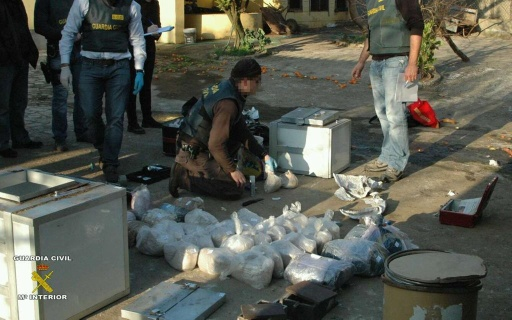

(320, 512, 3)
1  faces in the image


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide


(160, 256, 3)


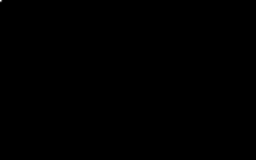

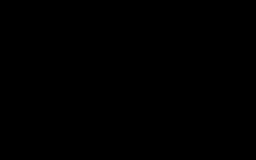

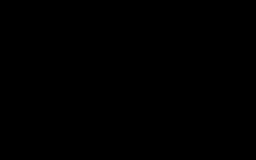

In [0]:
#visualise heatmaps and random crops

from google.colab.patches import cv2_imshow
x_img = cv2.imread("/gdrive/My Drive/Akash's Junk Folder/faces/x_images/9227.jpg")
cv2_imshow(x_img)
print(x_img.shape)
with open("/gdrive/My Drive/Akash's Junk Folder/faces/y_annotations/9227.json",'r') as f:
	y_annotations = json.loads(f.read())
print(len(y_annotations['0'])," faces in the image") 
heatmaps = create_heatmaps(x_img,y_annotations,num_classes=1,reduction=2)
print(heatmaps.shape)
cv2_imshow(heatmaps[:,:,0]*255)
cv2_imshow(heatmaps[:,:,1]*255000)# bounding boxes too small to be seen as heat maps
cv2_imshow(heatmaps[:,:,2]*255000)


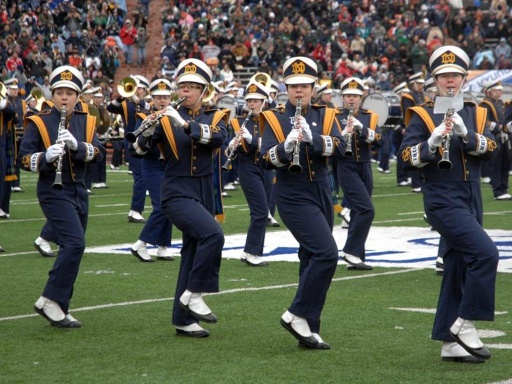

(384, 512, 3)
18  faces in the image


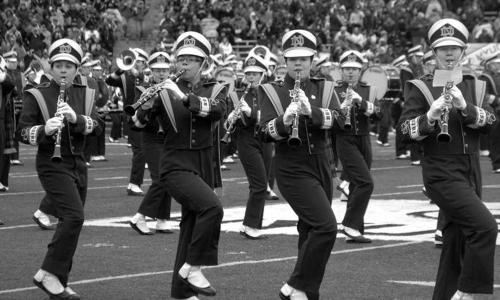

(300, 500, 1) (150, 250, 3)


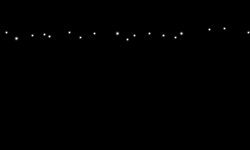

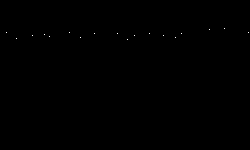

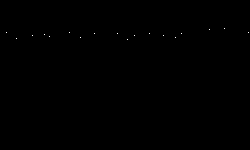

In [0]:
#visualize the random crop
from google.colab.patches import cv2_imshow
x_img = cv2.imread("/gdrive/My Drive/Akash's Junk Folder/faces/x_images/9.jpg")
cv2_imshow(x_img)
print(x_img.shape)
with open("/gdrive/My Drive/Akash's Junk Folder/faces/y_annotations/9.json",'r') as f:
	y_annotations = json.loads(f.read())
print(len(y_annotations['0'])," faces in the image") 
heatmaps = create_heatmaps(x_img,y_annotations,num_classes=1,reduction=2)

x_imgc,y_heatmaps = random_augment(x_img,heatmaps,gray=True,rand_crop=(300,500))

cv2_imshow(x_imgc)

print(x_imgc.shape,y_heatmaps.shape)
cv2_imshow(y_heatmaps[:,:,0]*255)
cv2_imshow(y_heatmaps[:,:,1]*255000)# bounding boxes too small to be seen as heat maps
cv2_imshow(y_heatmaps[:,:,2]*255000)


In [0]:
# do training on examples having height more than 300 pix and number of faces less than 35
inputs=[]
outputs=[]
for i_name in os.listdir(x_images_path):
  name = i_name.split('.')[0]
  x_img = cv2.imread(x_images_path+name+'.jpg')
	#read y_annotations_path+name+'.json'
  with open(y_annotations_path+name+'.json','r') as f:
    y_annotations = json.loads(f.read())	
  n_faces = len(y_annotations['0'])
  if n_faces<10 and x_img.shape[0]>300 and n_faces>4 and x_img.shape[0]<400:
    heatmaps = create_heatmaps(x_img,y_annotations,num_classes=1,reduction=2)
    x_imgc,y_heatmaps = random_augment(x_img,heatmaps,gray=True,rand_crop=(300,500))
    inputs.append(x_imgc/255.0 - 0.5)
    outputs.append(y_heatmaps)
    print(name,x_img.shape,heatmaps.shape,x_imgc.shape,y_heatmaps.shape,len(inputs),len(outputs))
  if len(inputs)>3000:
    break
print(len(inputs),len(outputs))
inputs = np.array(inputs)
outputs = np.array(outputs)
#divide by zero in 9232 or 9227
  	

9104 (384, 512, 3) (192, 256, 3) (300, 500, 1) (150, 250, 3) 1 1
912 (347, 512, 3) (173, 256, 3) (300, 500, 1) (150, 250, 3) 2 2
9148 (384, 512, 3) (192, 256, 3) (300, 500, 1) (150, 250, 3) 3 3
9156 (355, 512, 3) (177, 256, 3) (300, 500, 1) (150, 250, 3) 4 4
916 (381, 512, 3) (190, 256, 3) (300, 500, 1) (150, 250, 3) 5 5
9186 (335, 512, 3) (167, 256, 3) (300, 500, 1) (150, 250, 3) 6 6
9192 (384, 512, 3) (192, 256, 3) (300, 500, 1) (150, 250, 3) 7 7
9202 (341, 512, 3) (170, 256, 3) (300, 500, 1) (150, 250, 3) 8 8
9205 (340, 512, 3) (170, 256, 3) (300, 500, 1) (150, 250, 3) 9 9
9203 (350, 512, 3) (175, 256, 3) (300, 500, 1) (150, 250, 3) 10 10
9212 (342, 512, 3) (171, 256, 3) (300, 500, 1) (150, 250, 3) 11 11
9219 (341, 512, 3) (170, 256, 3) (300, 500, 1) (150, 250, 3) 12 12
9220 (340, 512, 3) (170, 256, 3) (300, 500, 1) (150, 250, 3) 13 13
9239 (330, 512, 3) (165, 256, 3) (300, 500, 1) (150, 250, 3) 14 14
924 (321, 512, 3) (160, 256, 3) (300, 500, 1) (150, 250, 3) 15 15
9242 (339, 512, 

In [0]:
model = create_architecture()
model.compile(loss=centernet_loss, optimizer=tf.keras.optimizers.Adam(lr=0.00001))	
print("loadinng a base model")
model.load_weights("/gdrive/My Drive/Akash's Junk Folder/2tiny_model.h5" )
model.fit(inputs[:2],outputs[:2],batch_size =1,epochs=1000,shuffle =True)#,validation_split=0.05)
print("saved at" ,"/gdrive/My Drive/Akash's Junk Folder/2tiny_model.h5" )
model.save_weights( "/gdrive/My Drive/Akash's Junk Folder/2tiny_model.h5")

# initially the model is trained in 2 examples(made to overfit ) to reduce wild outputs in the feature map
#the the model is reloaded and trained on  more exampes 300,500 then 400,500 images 
# if u train it fro scratch on huge number of examples due to wild outputs in heat map the loss will be huge

In [44]:
print("saved at" ,"/gdrive/My Drive/Akash's Junk Folder/2tiny_model.h5" )
model.save_weights( "/gdrive/My Drive/Akash's Junk Folder/2tiny_model.h5")

saved at /gdrive/My Drive/Akash's Junk Folder/2tiny_model.h5


It can be clearly seen that the loss function works since our simple model was able to give proper outputs when overfitted on 2 images

(300, 500, 1) (150, 250, 3)


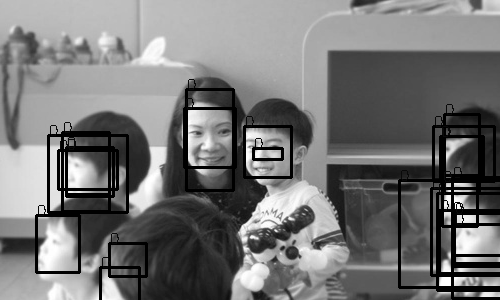

{0: [[0.10495281, 399, 180, 580, 287], [0.11095461, 452, 177, 503, 298], [0.11418104, 66, 147, 113, 196], [0.11467168, 109, 243, 146, 276], [0.12757087, 431, 188, 548, 275], [0.12854886, 186, 89, 233, 190], [0.14260268, 444, 114, 479, 193], [0.15323025, 441, 136, 482, 179], [0.15552497, 253, 148, 282, 159], [0.1562908, 58, 150, 117, 189], [0.15740976, 454, 224, 505, 255], [0.15897459, 433, 126, 494, 181], [0.16870561, 452, 212, 507, 263], [0.18207729, 48, 135, 127, 212], [0.18837279, 439, 210, 516, 273], [0.19720995, 440, 136, 479, 179], [0.19973892, 437, 193, 514, 290], [0.43013963, 62, 132, 109, 211], [0.7398179, 454, 213, 501, 266], [0.76050484, 66, 149, 109, 194], [0.7747643, 440, 136, 483, 175], [0.86073697, 36, 215, 79, 272], [0.9003707, 184, 108, 235, 167], [0.9140156, 442, 181, 477, 226], [0.91933644, 244, 126, 291, 177], [0.9641843, 100, 267, 139, 328]]}
(300, 500, 1) (150, 250, 3)


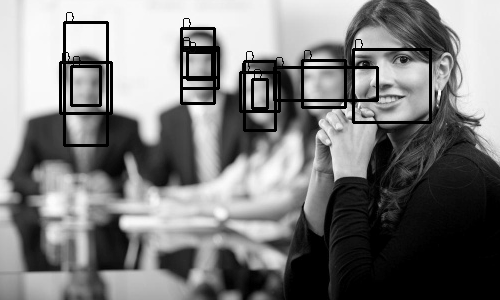

{0: [[0.10397169, 244, 61, 275, 130], [0.119344294, 181, 28, 214, 103], [0.12290567, 181, 50, 218, 77], [0.1321797, 64, 22, 107, 145], [0.16089335, 274, 67, 377, 100], [0.20573059, 60, 62, 111, 113], [0.23597032, 252, 79, 267, 108], [0.33099216, 187, 52, 212, 79], [0.8204622, 181, 47, 218, 88], [0.84093595, 240, 72, 279, 111], [0.85318613, 302, 60, 345, 107], [0.85373616, 71, 66, 100, 105], [0.9567226, 353, 49, 430, 122]]}


In [54]:
#x_img = cv2.imread("/gdrive/My Drive/Akash's Junk Folder/faces/x_images/1220.jpg")
#x_imgb = cv2.cvtColor(x_img, cv2.COLOR_BGR2GRAY).reshape((x_img.shape[0],x_img.shape[1],1))
#hmp=model.predict(np.array([x_imgb/255.0 -0.5]))[0]
hmp = model.predict(np.array([inputs[0]]))[0]

print(inputs[0].shape,hmp.shape)
bbx = visualize_y_heatmap((inputs[0]+0.5)*255,hmp,min_conf=0.1, max_obj_pc = 100 )
print(bbx)

hmp = model.predict(np.array([inputs[1]]))[0]

print(inputs[1].shape,hmp.shape)
bbx = visualize_y_heatmap((inputs[1]+0.5)*255,hmp,min_conf=0.1, max_obj_pc = 100 )
print(bbx)

In [0]:
model = create_architecture()
model.compile(loss=centernet_loss, optimizer=tf.keras.optimizers.Adam(lr=0.00001))	
print("loadinng a base model")
model.load_weights("/gdrive/My Drive/Akash's Junk Folder/tiny_model.h5" )
model.fit(inputs[:2],outputs[:2],batch_size =1,epochs=1000,shuffle =True)#,validation_split=0.05)
print("saved at" ,"/gdrive/My Drive/Akash's Junk Folder/tiny_model.h5" )
model.save_weights( "/gdrive/My Drive/Akash's Junk Folder/tiny_model.h5")

# initially the model is trained in 2 examples(made to overfit ) to reduce wild outputs in the feature map
#the the model is reloaded and trained on  more exampes 300,500 then 400,500 images 
# if u train it fro scratch on huge number of examples due to wild outputs in heat map the loss will be huge

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_273 (Conv2D)          (None, None, None, 32)    320       
_________________________________________________________________
conv2d_274 (Conv2D)          (None, None, None, 64)    18496     
_________________________________________________________________
conv2d_275 (Conv2D)          (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_276 (Conv2D)          (None, None, None, 128)   73856     
_________________________________________________________________
conv2d_277 (Conv2D)          (None, None, None, 128)   147584    
_________________________________________________________________
conv2d_278 (Conv2D)          (None, None, None, 128)   147584    
_________________________________________________________________
conv2d_279 (Conv2D)          (None, None, None, 3)   

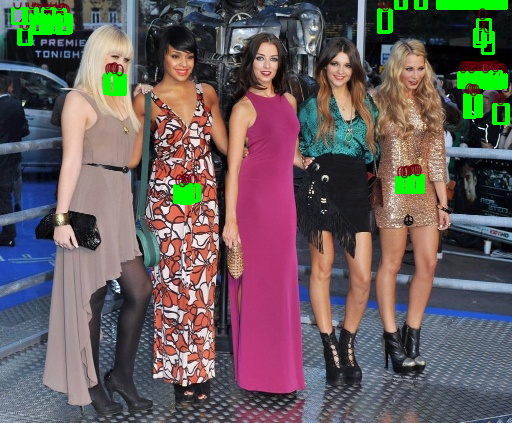

{0: [[0.00026649237, 182, 185, 193, 202], [0.0002771318, 40, 14, 51, 33], [0.00028559566, 188, 185, 199, 200], [0.0002900958, 410, 175, 421, 192], [0.00029930472, 106, 74, 117, 93], [0.00031587481, 186, 184, 197, 201], [0.00031787157, 463, 72, 472, 87], [0.00031933188, 461, 72, 470, 87], [0.00032645464, 475, -4, 484, 8], [0.00032669306, 60, 15, 71, 32], [0.00032812357, 108, 74, 119, 93], [0.00032934546, 477, -4, 486, 8], [0.00032949448, 473, -4, 482, 8], [0.00033682585, 481, -4, 490, 8], [0.0003375411, 408, 175, 419, 192], [0.00033923984, 479, -4, 488, 8], [0.00034049153, 471, -4, 480, 8], [0.00034072995, 465, 72, 474, 87], [0.0003451705, 497, 74, 506, 87], [0.00034588575, 495, -4, 504, 8], [0.00034669042, 469, -4, 478, 8], [0.00034824014, 495, 74, 504, 87], [0.00034835935, 471, 73, 480, 86], [0.00034844875, 493, 104, 506, 123], [0.000351429, 497, -4, 506, 8], [0.00035318732, 483, -4, 492, 8], [0.00035354495, 32, 14, 43, 33], [0.00035586953, 43, 15, 52, 32], [0.00035586953, 458, 72, 46

In [83]:
model = create_architecture()
model.compile(loss=centernet_loss, optimizer=tf.keras.optimizers.Adam(lr=0.00001))	
print("loadinng a base model")
model.load_weights("/gdrive/My Drive/Akash's Junk Folder/tiny_model.h5" )
x_img = cv2.imread("/gdrive/My Drive/Akash's Junk Folder/faces/x_images/99.jpg")
x_imgb = cv2.cvtColor(x_img, cv2.COLOR_BGR2GRAY).reshape((x_img.shape[0],x_img.shape[1],1))
hmp=model.predict(np.array([x_imgb/255.0 -0.5]))[0]

print(x_img.shape,hmp.shape)
bbx = visualize_y_heatmap(x_img,hmp,min_conf=0.0, max_obj_pc = 100 )
print(bbx)

As it can be seen the model performs very bad.
Reasons
mostly due to shallow architecture and the fact that its trained only on 1000 images.The random cropping done might not be the best way to  fix input size to fit a batch.
Also the visualization shown here is not how actual inference is done . for that we need to add maxpool layers at the ned to perform nonmax supression.

here we define custom batch training that takes images and y_annotations.json and creates label heatmaps during training and also real time augmenting the dataset for reducing overfitting
This is not the most optimized way of training but its simple to understand and work upon(BUT IS TOO SLOW . INSTEAD SAVING RESIZED IMAGES HEATMAPS IN DISK
AND USING A DATA (FIT) GENERATOR MIGHT BE BETTER) 

In [0]:
epochs = 500
batch_size = 8
dataset_length = len( x_data_list )
#val
batches = dataset_length//batch_size
mod = batches//10
for i in range(epochs):
	print("epoch :",i)
	print("training on ",len(x_data_list)," examples", "validating on " , len([]) , " examples")
	print("[",end= '')
	totloss=0
	random.shuffle(x_data_list)# shuffle the list
	ctr = 0
	for j in range(0,dataset_length,batch_size):
		if j+batch_size<dataset_length:
			batch_list = x_data_list[j:j+batch_size]
		else:
			batch_list = x_data_list[j:dataset_length]
		#preprocessing pipeline for batch
		x_batch=[]
		y_batch=[]
		#preparing batch
		for data in batch_list:
			x_img = cv2.imread(x_images_path+data+'.jpg')
			#read y_annotations_path+data+'.json'
			with open(y_annotations_path+data+'.json','r') as f:
				y_annotations = json.loads(f.read())		
			#get y_heatmaps
			y_heatmaps = create_heatmaps(x_img,y_annotations,num_classes=1,reduction=2)
			#augment images and heatmaps
			x_img,y_heatmaps = random_augment(x_img,y_heatmaps,gray=True,rand_crop=(200,200))#200 512 # min shape
			#normalize the input images
			x_img = x_img/255.0-0.5 # keep pixels between -0.5 to 0.5
			#append to batch list
			x_batch.append(x_img)
			y_batch.append(y_heatmaps)

		#train on batch
		loss = model.train_on_batch(np.array(x_batch),np.array(y_batch))
		totloss += loss
		ctr+=1
		print("=",end='')
	print("]")		
	print("total loss :",totloss,"| steps:",ctr ,"| avg loss :",totloss/ctr)		
	print("_"*50)		
	print("saved at" ,"/gdrive/My Drive/Akash's Junk Folder/tiny_model.h5" )
	model.save_weights( "/gdrive/My Drive/Akash's Junk Folder/tiny_model.h5")